# Defensive Distillation

__Objective__: Mitigate the model with **untargeted attacks** using **Defensive Distillation** method. You will prepare a training dataset that will contain only two classes (i.e. 0 and 1) because this method has a long runtime. You can increase the number of classes used if the computing environment you are using allows more significant amounts of data to run. Since implementing the Defensive distillation method is complex, I am sharing the Distillation class in this study. Your task is to create a more resistant model to attack using this class.

__Workflow__:
1.  Load the `Traffic Sign` dataset and examine its structure.
    - Download `tsrd-train` from http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html.
    - Take a closer look at the data inspecting it's size, shape, and quantity.
    - View some random samples using either OpenCV or Matplotlib (or others) of the handwritten digits and observe the complexity of the images. Do you have any issues identify these written numbers?
2. Using `numpy` or other libraries prepare your dataset for training
    - Ensure the format or shape of the data is appropriate for input into your model (one-hot-encoding is needed for the labels)
    - Ensure data types are correct and that data is normalized. 
    - Use only images belongs to class `1` and `2`
3. Create and build a **teacher model**
    - Train the model using training dataset
    - Plot training history using `plot_keras_history`'s `plot_history` method.
4. **Distillation**
    - Create another student model
    - Create **distiller model** using `Distiller` class with **trained teacher** and newly created **student** models.
    - Train the **distiller model**
    - Plot training history using `plot_keras_history`'s `plot_history` method.
    - Generate malicious inputs based on testX and FGSM attack using CleverHans' `fast_gradient_method` class with 0.03 epsilon value
    - Evaluate the prediction accuracy of the **student model** using sklearn's `accuracy_score` method with malicious inputs

__Deliverable__:

The deliverable is a Jupyter Notebook documenting your workflow.

In [1]:
!pip install -q cleverhans
!pip install -q plot_keras_history

In [2]:
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense

from plot_keras_history import plot_history
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix,accuracy_score

import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from keras.preprocessing.image import  img_to_array
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.patches as patches
import keras
import tensorflow as tf

import seaborn as sns

from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

np.random.seed(10)

COLAB_ENABLED = False

In [3]:
if COLAB_ENABLED:
    from google.colab import drive
    drive.mount("/content/gdrive")

    DS_PATH = '/content/gdrive/My Drive/ds/dataset.npz'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
IMAGE_PATH_TRAIN = '/Users/ozgur/Downloads/tsrd-train/'
COL_NAMES = ['filename','f1','f2','x1','y1','x2','y2','label']
IMAGE_SIZE = (134,128)
EPOCHS = 2000
BS = 500
STUDENT_MODEL_MULTIPLICATION = 0.5
TEACHER_MODEL_MULTIPLICATION = 10.0

In [5]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [6]:
def get_model(input_shape, num_of_class, multiplication_factor, model_name):
    model = Sequential()
    model.add(Conv2D(32*multiplication_factor, (5, 5),activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    
    model.add(Conv2D(32*multiplication_factor, (5, 5),activation='relu'))
    model.add(MaxPooling2D(pool_size=(5, 5)))
    
    model.add(Flatten())  
    model.add(Dense(np.int32(64*multiplication_factor), activation='relu',))
    model.add(Dropout(0.2))
    model.add(Dense(num_of_class, activation='softmax'))
     
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [7]:
# Step 1
data = []
labels = []

df = pd.read_csv('TsignRecgTrain4170Annotation.txt',names=COL_NAMES,sep=';', index_col=False)
df = df.query('label <= 1')

for index, row in df.iterrows():
    fname = IMAGE_PATH_TRAIN + row['filename']
    image = cv2.imread(fname)
    image = cv2.resize(image, IMAGE_SIZE)
    image = img_to_array(image)
    data.append(image)
    
    label = df.query("filename=='" + os.path.split(fname)[1] + "'").label.values[0]
    labels.append(label)
    
data = np.array(data) / 255.0
labels = to_categorical(labels)

print("Total dataset size:", data.shape[0])
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, random_state=42)

Total dataset size: 158


## Defensive Distillation

In [9]:
student_model = get_model(data[0,:].shape, labels.shape[1],
                          multiplication_factor=STUDENT_MODEL_MULTIPLICATION, model_name='Student')
teacher_model = get_model(data[0,:].shape, labels.shape[1],
                          multiplication_factor=TEACHER_MODEL_MULTIPLICATION, model_name='Teacher')

### train Teacher model

In [10]:
es_teacher = EarlyStopping(monitor='val_loss', 
                   patience=20, 
                   min_delta=0.001,
                   verbose=1,
                   restore_best_weights=True,
                   mode='min')

teacher_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Train and evaluate teacher on data.
hist_teacher = teacher_model.fit(trainX,trainY,
              batch_size=BS,
              epochs=EPOCHS,
              verbose=0,
              callbacks=[es_teacher],
              validation_data=(testX, testY))
teacher_model.evaluate(testX, testY)

Restoring model weights from the end of the best epoch: 63.
Epoch 00083: early stopping
1/1 [==============================] - 0s 209ms/step - loss: 0.0012 - accuracy: 1.0000


[0.0011807072442024946, 1.0]

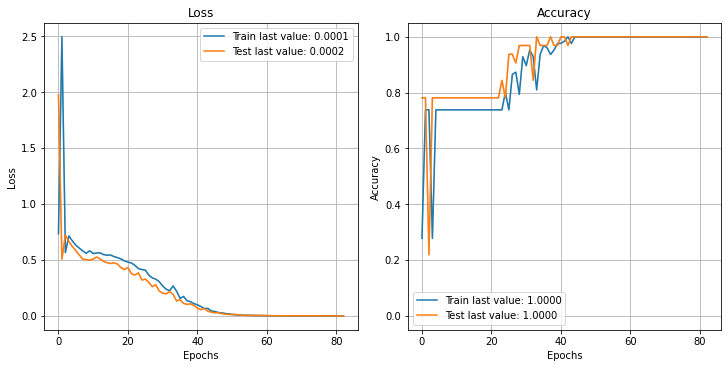

In [11]:
plot_history(hist_teacher.history)
plt.show()

In [12]:
student_model = get_model(data[0,:].shape, labels.shape[1],
                          multiplication_factor=STUDENT_MODEL_MULTIPLICATION, model_name='Student')

distiller = Distiller(student=student_model, teacher=teacher_model)
loss_fn = keras.losses.CategoricalCrossentropy()

distiller.compile(optimizer='adam',
                            metrics=['categorical_crossentropy'],
                            student_loss_fn=loss_fn,
                            distillation_loss_fn=keras.losses.KLDivergence(),
                            alpha=0.1,
                            temperature=10)

es = EarlyStopping(monitor='student_loss', 
                   patience=20, 
                   #min_delta=0.0001,
                   verbose=1,
                   restore_best_weights=True,
                   mode='min')

hist_distill = distiller.fit(trainX,trainY,
                              batch_size=BS,
                              epochs=EPOCHS,
                              verbose=0,
                              callbacks=[es],
                              validation_data=(testX, testY))

Restoring model weights from the end of the best epoch: 116.
Epoch 00136: early stopping


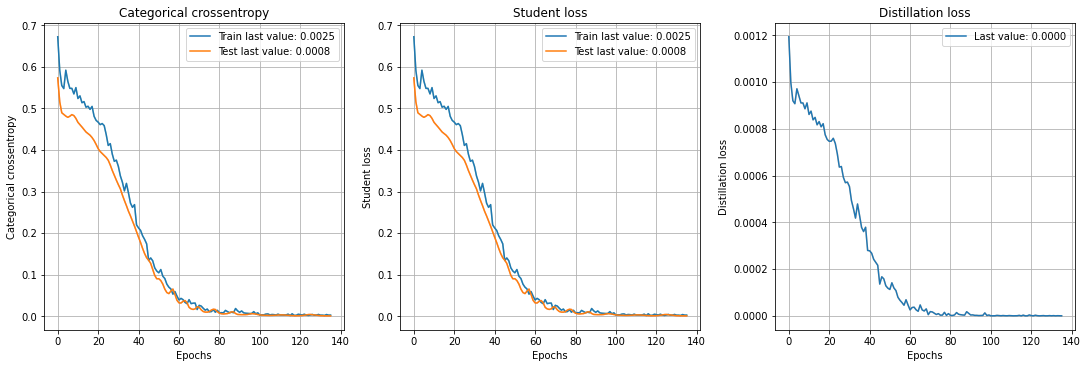

In [13]:
plot_history(hist_distill.history)
plt.show()

In [14]:
predictions = distiller.student.predict(testX)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(testY, axis=1)) / len(testY)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 100.0%


In [15]:
logits_model = tf.keras.Model(distiller.student.input, distiller.student.layers[-1].output)

In [16]:
# Step 3: Generate adversarial test examples with **targeted Projected Gradient Descent** attack
ATTACK_POWER = 0.03
x_test_adv_fgsm = fast_gradient_method(logits_model, 
                                       testX,clip_min = 0.0, clip_max=1.0,
                                       eps=ATTACK_POWER, norm=np.inf)

In [17]:
y_adv_pred_fgsm = distiller.student.predict(x_test_adv_fgsm)
acc = accuracy_score(testY.argmax(axis=1), y_adv_pred_fgsm.argmax(axis=1))
print('Accuracy:{}'.format(acc))

Accuracy:0.84375
